# Importing libraries

In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

In [293]:
def mse(observations, estimates):
    # checking arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # checking length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)

    return mse

# Data

## Loading data

In [294]:
data = pd.read_csv("AirPassengers.csv")
print("Number of records: ", len(data))
data.head()

Number of records:  144


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Preprocessing data

Checking duplicates

In [295]:
data[data.duplicated()]

,Month,#Passengers


Checking null-values

In [296]:
print(data.isnull().sum())

Month          0
#Passengers    0
dtype: int64


Checking data types

In [297]:
print(data.dtypes)

Month          object
#Passengers     int64
dtype: object


In [298]:
data["Date"] = pd.to_datetime(data["Month"])
print(data["Date"])

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Date, Length: 144, dtype: datetime64[ns]


I divided the data into three chunks:
1. train_data - 80%
2. test_data - 20%

In [299]:
n = len(data)
train_size = int(0.8*n)
test_size = n - train_size
print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  115
Test size:  29


In [300]:
train_data = np.array(data['#Passengers'][:train_size])
test_data = np.array(data['#Passengers'][-test_size:])

## Data visualisation

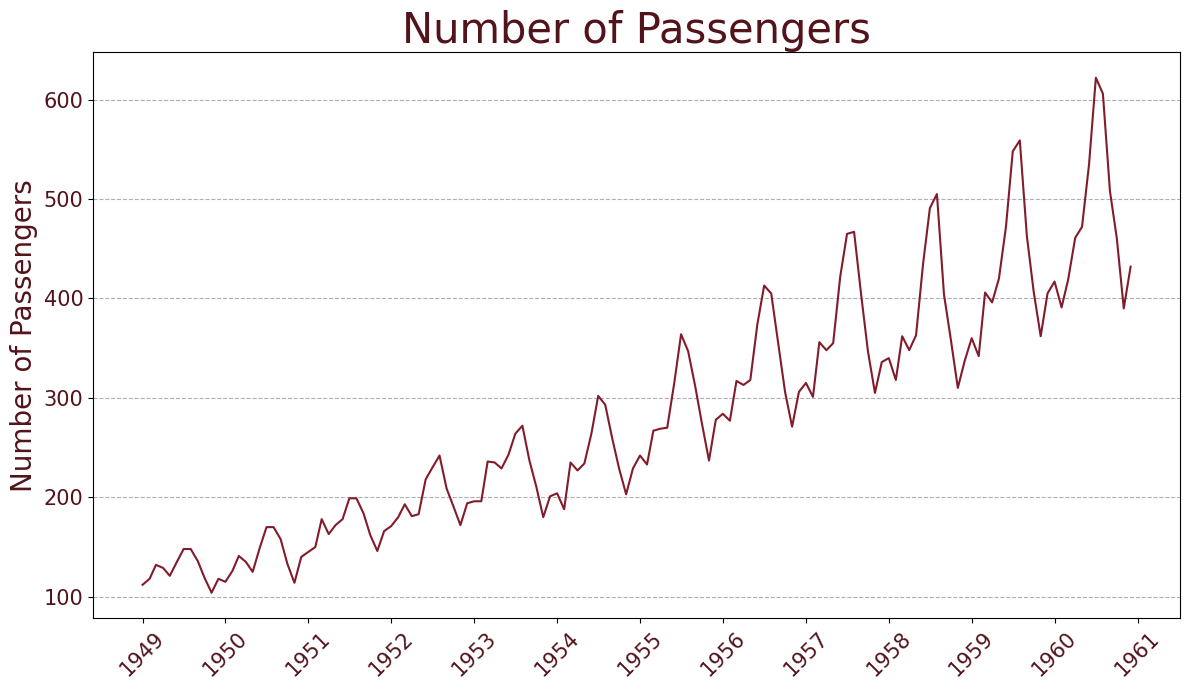

In [301]:
plt.figure(figsize=(12,7))
plt.title("Number of Passengers", fontsize = 30, color='#52131b')
plt.plot(data["Date"], data["#Passengers"], color="#821c2a")
plt.ylabel("Number of Passengers", fontsize = 20, color="#52131b")
plt.xticks(rotation = 45, fontsize=15, color="#52131b")
plt.yticks(fontsize=15, color="#52131b")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(axis="y", linestyle = "--")
plt.tight_layout()
plt.show()

In the plot, we can see that the data exhibits both a trend and seasonality. It also appears that the variance increases over time, which can be confirmed by splitting the data into chunks and examining their variance.

In [302]:
chunks = np.split(train_data[:-5], indices_or_sections=10)
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 127.455 | 180.793
    2 | 140.0 | 346.364
    3 | 165.636 | 628.231
    4 | 188.364 | 814.05
    5 | 215.0 | 713.273
    6 | 223.0 | 783.818
    7 | 254.182 | 812.331
    8 | 301.636 | 1183.32
    9 | 338.182 | 1896.15
   10 | 373.364 | 2944.78


The mean and variance vary greatly over time which means this data is not stationary and has trend and heteroscedasticity.

# Seasonal decomposition (multiplicative model)

Let’s decompose this time series into its components. For this, I will use a multiplicative model.

In [303]:
ss_decomposition = seasonal_decompose(x=train_data, model='multiplicative', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

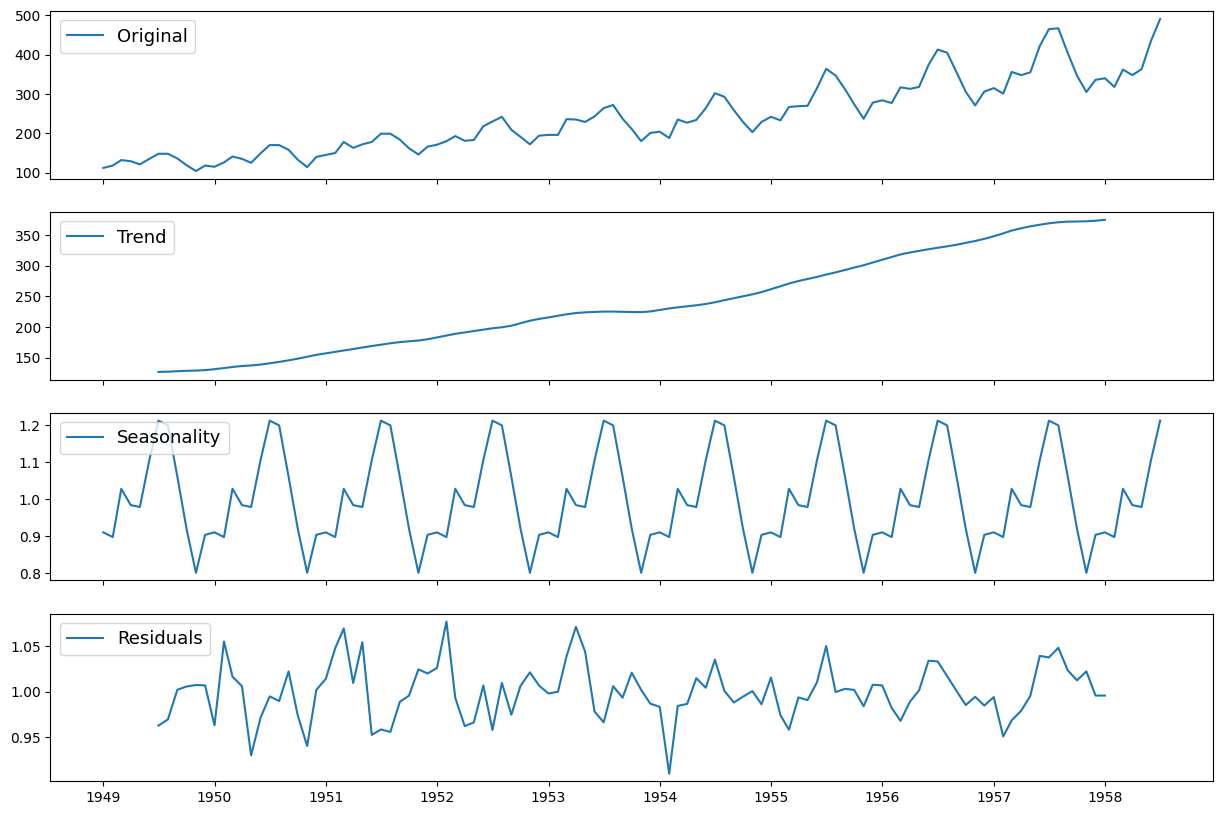

In [304]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data["Date"][:train_size], train_data, label='Original')
axes[0].legend(loc='upper left', fontsize=13)

axes[1].plot(data["Date"][:train_size], estimated_trend, label='Trend')
axes[1].legend(loc='upper left', fontsize=13)

axes[2].plot(data["Date"][:train_size], estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left', fontsize=13)

axes[3].plot(data["Date"][:len(estimated_residual)], estimated_residual, label='Residuals')
axes[3].legend(loc='upper left', fontsize=13)

fig.gca().xaxis.set_major_locator(mdates.YearLocator())
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

The plot shows the decomposition into trend, seasonality, and residuals. It now becomes clearer that the data has a seasonality pattern with a cycle length of 12 months.

# Exponential Smoothing

For forecasting in this project, I have chosen the exponential smoothing method. I will also compare single exponential smoothing, double exponential smoothing, and triple exponential smoothing.

## Single Exponential

In [305]:
single = SimpleExpSmoothing(train_data).fit(optimized=True)
single_preds = single.forecast(len(test_data))
single_mse = mse(test_data, single_preds)
# print("Predictions: ", single_preds)
print("MSE: ", round(single_mse))

MSE:  250718


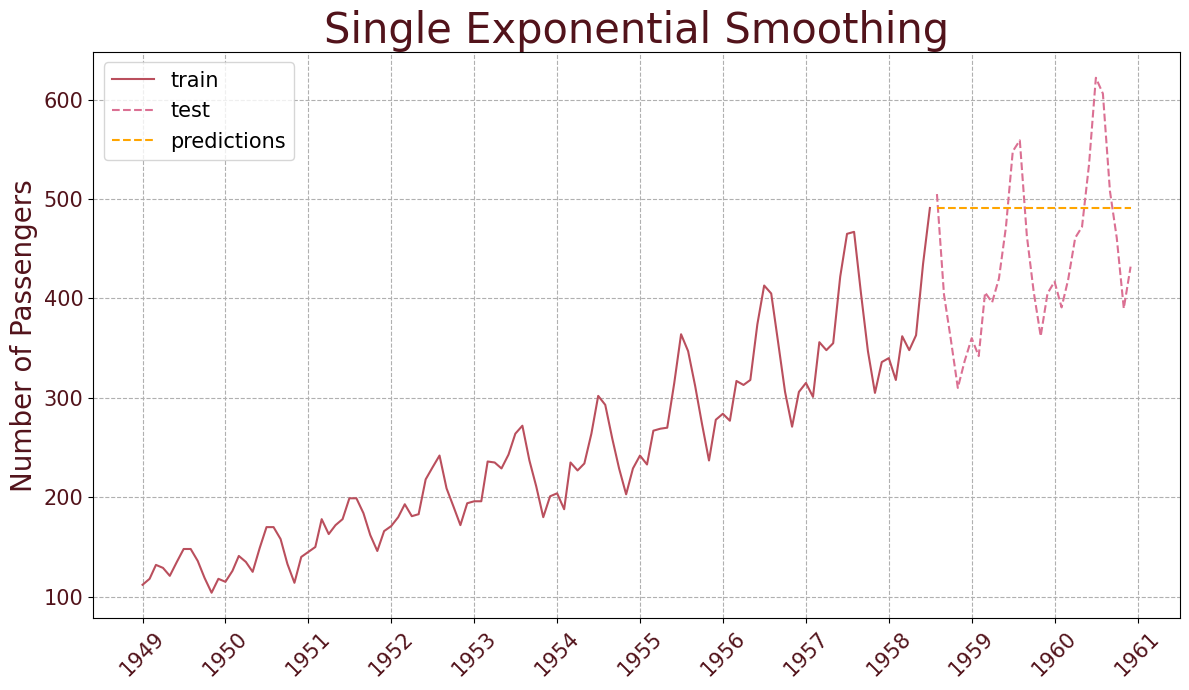

In [306]:
plt.figure(figsize=(12,7))
plt.title("Single Exponential Smoothing", fontsize = 30, color='#52131b')
plt.plot(data["Date"][:train_size], train_data, color='#ba4f5d', label="train")
plt.plot(data["Date"][train_size:], test_data, color='palevioletred', linestyle="--", label="test")
plt.plot(data["Date"][train_size:], single_preds, color='orange', linestyle='--', label="predictions")
plt.ylabel("Number of Passengers", fontsize = 20, color="#52131b")
plt.xticks(rotation = 45, fontsize=15, color="#52131b")
plt.yticks(fontsize=15, color="#52131b")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(loc='upper left', fontsize=15)
plt.grid(axis="both", linestyle = "--")
plt.tight_layout()
plt.show()

As we can see, this method does not take into account the trend and seasonality, which is why it is not an effective method for forecasting this data

## Double Exponential

In [307]:
double = Holt(train_data).fit(optimized=True)
double_preds = double.forecast(len(test_data))
double_mse = mse(test_data, double_preds)
# print("Predictions: ", double_preds)
print("MSE: ", round(double_mse))

MSE:  686724


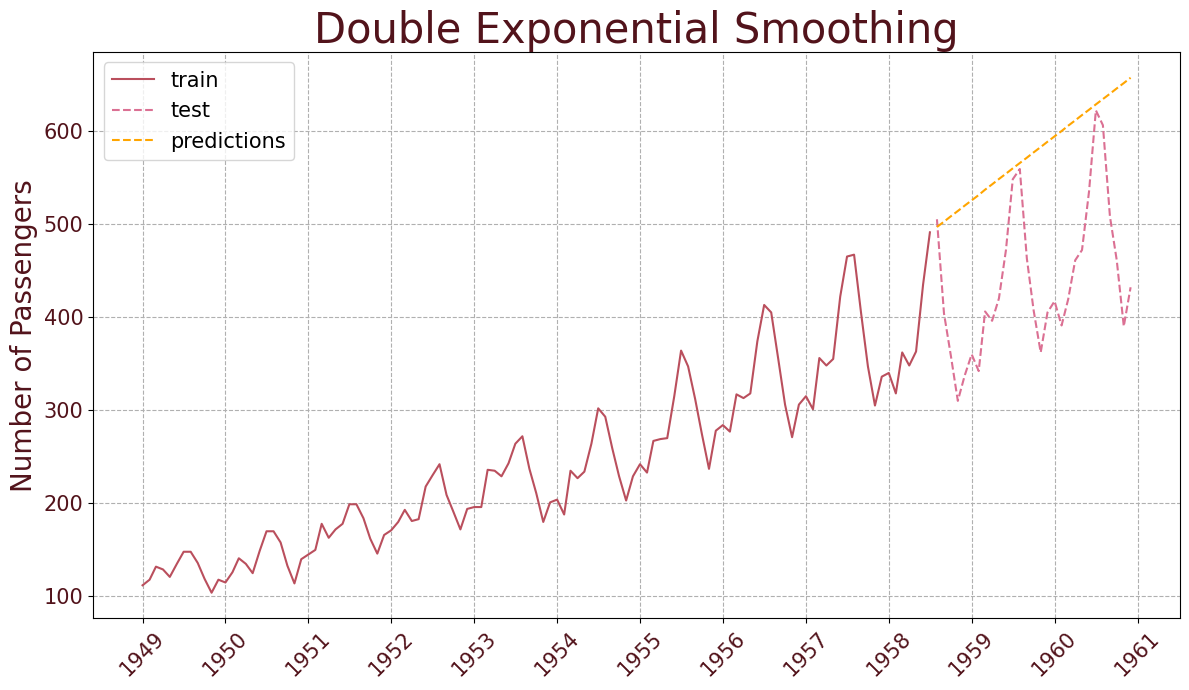

In [308]:
plt.figure(figsize=(12,7))
plt.title("Double Exponential Smoothing", fontsize = 30, color='#52131b')
plt.plot(data["Date"][:train_size], train_data, color='#ba4f5d', label="train")
plt.plot(data["Date"][train_size:], test_data, color='palevioletred', linestyle="--", label="test")
plt.plot(data["Date"][train_size:], double_preds,color='orange', linestyle='--', label="predictions")
plt.ylabel("Number of Passengers", fontsize = 20, color="#52131b")
plt.xticks(rotation = 45, fontsize=15, color="#52131b")
plt.yticks(fontsize=15, color="#52131b")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(loc='upper left', fontsize=15)
plt.grid(axis="both", linestyle = "--")
plt.tight_layout()
plt.show()

As we can see, this method takes into account the trend, but does not take into account seasonality.

## Triple Exponential

In [309]:
triple = ExponentialSmoothing(train_data,
                              trend="additive",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test_data))
triple_mse = mse(test_data, triple_preds)
# print("Predictions: ", triple_preds)
print("MSE: ", round(triple_mse))

MSE:  19664


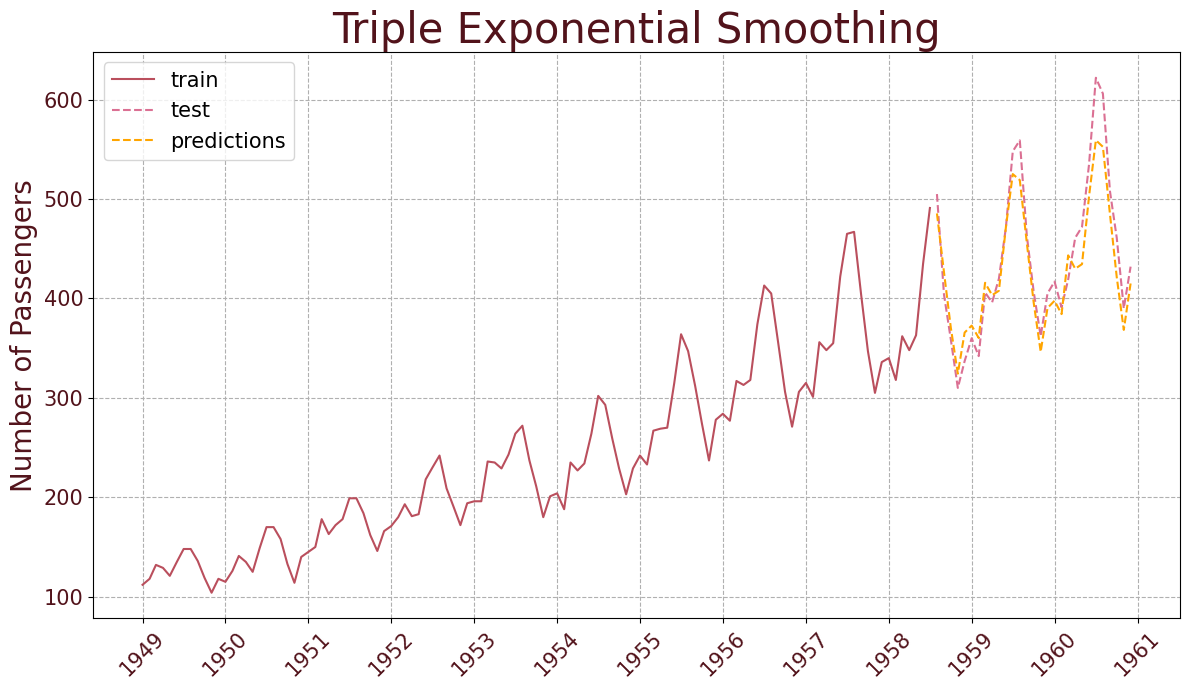

In [310]:
plt.figure(figsize=(12,7))
plt.title("Triple Exponential Smoothing", fontsize = 30, color='#52131b')
plt.plot(data["Date"][:train_size], train_data, color='#ba4f5d', label="train")
plt.plot(data["Date"][train_size:], test_data, color='palevioletred', linestyle="--", label="test")
plt.plot(data["Date"][train_size:], triple_preds, color='orange', linestyle='--', label="predictions")
plt.ylabel("Number of Passengers", fontsize = 20, color="#52131b")
plt.xticks(rotation = 45, fontsize=15, color="#52131b")
plt.yticks(fontsize=15, color="#52131b")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(loc='upper left', fontsize=15)
plt.grid(axis="both", linestyle = "--")
plt.tight_layout()
plt.show()

Triple exponential smoothing takes into account both the trend and seasonality, which makes it possible to predict the data well. Therefore, the MSE of this method is smaller than the MSE of the single and double exponential smoothing

# Retraining best model

In [311]:
print('Single Exponential Smoothing MSE: ', round(single_mse))
print('Double Exponential Smoothing MSE: ', round(double_mse))
print('Triple Exponential Smoothing MSE: ', round(triple_mse))

Single Exponential Smoothing MSE:  250718
Double Exponential Smoothing MSE:  686724
Triple Exponential Smoothing MSE:  19664


The least MSE has triple exponential smoothing, so it predicts the data better. Now we can retrain this model using train data + test data

In [312]:
final_triple = ExponentialSmoothing(np.concatenate((train_data, test_data),axis=0),
                              trend="additive",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)

# Forecasting data for the next two years

In [313]:
final_preds = final_triple.forecast(24)

In [314]:
future_dates = pd.date_range(
    # start=data["Date"].iloc[-1] + pd.offsets.MonthBegin(1),
    start=data["Date"].iloc[-1],
    periods=len(final_preds),
    freq='ME'
)
future_dates

DatetimeIndex(['1960-12-31', '1961-01-31', '1961-02-28', '1961-03-31',
               '1961-04-30', '1961-05-31', '1961-06-30', '1961-07-31',
               '1961-08-31', '1961-09-30', '1961-10-31', '1961-11-30',
               '1961-12-31', '1962-01-31', '1962-02-28', '1962-03-31',
               '1962-04-30', '1962-05-31', '1962-06-30', '1962-07-31',
               '1962-08-31', '1962-09-30', '1962-10-31', '1962-11-30'],
              dtype='datetime64[ns]', freq='ME')

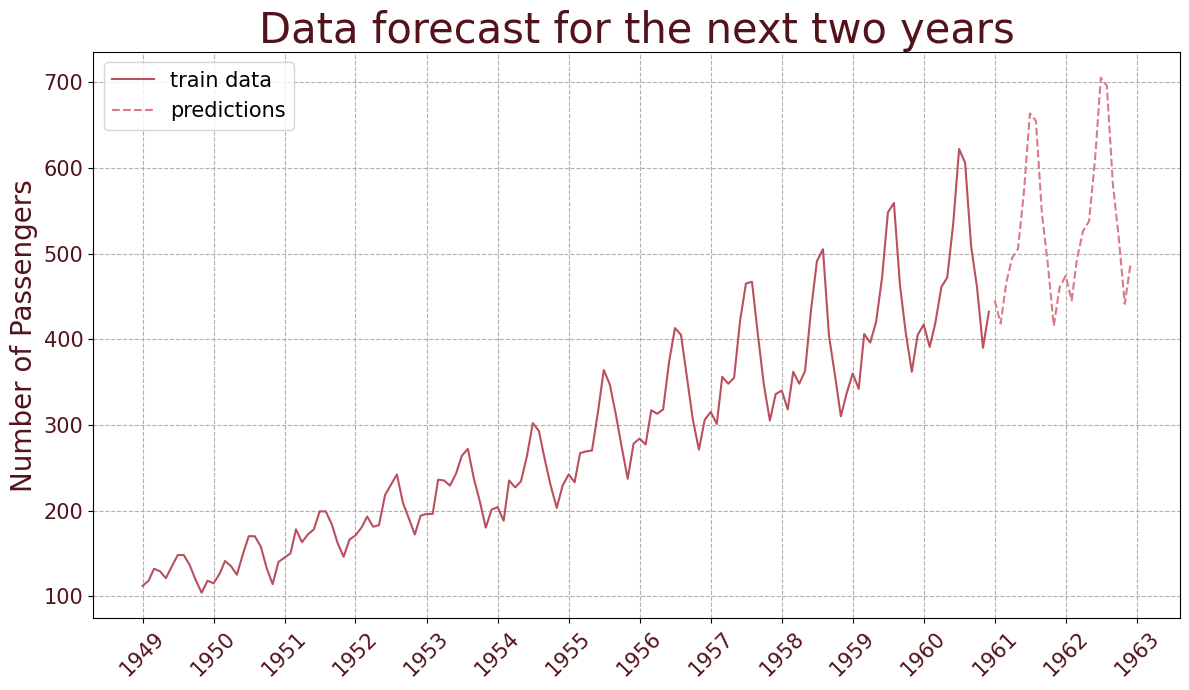

In [315]:
plt.figure(figsize=(12,7))
plt.title("Data forecast for the next two years", fontsize = 30, color='#52131b')
plt.plot(data["Date"], np.concatenate((train_data, test_data),axis=0), color='#ba4f5d', label="train data")
plt.plot(future_dates, final_preds, color="#db7a87", linestyle='--', label="predictions")
plt.ylabel("Number of Passengers", fontsize = 20, color="#52131b")
plt.xticks(rotation = 45, fontsize=15, color="#52131b")
plt.yticks(fontsize=15, color="#52131b")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(loc='upper left', fontsize=15)
plt.grid(axis="both", linestyle = "--")
plt.tight_layout()
plt.show()